In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import signal
from scipy.stats import zscore
from plotnine import *
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

In [2]:
def _runs(arr, val):
    """
    Return a (n, 2) array where rows correspond to the start and stop
    indexes of runs of consecutive values in arr

    Args:
        arr (array-like): array in which to search for runs
        value (float): value for which runs will be searched
    """
    is_val = np.equal(arr, val).view(np.uint8)
    is_val = np.concatenate((np.array([0]), is_val, np.array([0])))
    absdiff = np.abs(np.diff(is_val))
    return np.where(absdiff == 1)[0].reshape(-1, 2)


def mean_bouts(x):
    runs = _runs(x, val=1)
    runs = np.apply_along_axis(lambda x: x[1] - x[0], 1, runs)
    return np.mean(runs)

In [65]:
def cross_correlation(s1, s2, num_lags=None, 
                      standardise=False, standardise_range="all"):
    out = signal.correlate(s1, s2, mode="same")
    if standardise and standardise_range=="all":
        out = zscore(out)
    if num_lags:
        zero_idx = len(out) // 2
        out = out[zero_idx-num_lags:zero_idx+num_lags+1]
    if standardise and standardise_range=="sub":
        out = zscore(out)
    return out

def cc_lags(cc, interval):
    num_lags = len(cc) // 2
    return np.arange(-num_lags, (num_lags + 1)) * interval

def corss_corr_by(x, num_lags=300, standardise=False, standardise_range="all"):
    fps = x.iloc[0].fps
    dem = x.was_freezing_dem.values
    obs = x.was_freezing_obs.values
    zcc = cross_correlation(dem, obs, num_lags=num_lags, standardise=standardise,
                           standardise_range=standardise_range)
    lags = cc_lags(zcc, 1/fps)
    return pd.DataFrame({
        "lag": lags,
        "cc": zcc,
        })

In [4]:
df = pd.read_csv(r"C:\Users\rory\repos\ah_vids\output\FP\new\conditioning.csv")

In [5]:
df = (
    df
    .assign(is_CS_ff = lambda x: (x.trial_num >= (x.trial_num.max() - 5)) & (x.trial_type == "CS"),
            is_CS_lf = lambda x: (x.trial_num < - 5)  & (x.trial_type == "CS"),
            is_US =  lambda x: (x.aligned <= 2) & (x.trial_type == "ITI")
           )
)

## FREEZING

### Group Differences of overall Freezing

In [7]:
def get_freeze_ts(df, rolling_window=10, col="was_freezing_dem"):
    return (
        df
    .dropna()
    .groupby(["group", np.round(df.exp_time)])
    [col]
    .mean()
    .reset_index()
    .dropna()
    .groupby(["group"])
    .rolling(window=rolling_window)
    .mean()
    .dropna()
    .reset_index()
    )

In [8]:
def get_cs_starts():
    return np.array([180 + i * 30 for i in range(61) if i %2 == 0])

def get_cs_stops():
    return get_cs_starts() + 29.9

def get_iti_starts():
    return np.array([180 + i * 30 for i in range(61) if not i %2 == 0])

def get_iti_stops():
    return get_iti_starts() + 29.9

def filler(ax, start, stop, color, alpha, label=None):
    ax.axvspan(start, stop, color=color, alpha=alpha, label=label)
    return ax

def fill_background(ax, cs_color="red", iti_color="grey", alpha=0.2, seconds=False):
    cs_starts = get_cs_starts()
    cs_stops = get_cs_stops()
    iti_starts = get_iti_starts()
    iti_stops = get_iti_stops()
    for i, (start, stop) in enumerate(zip(cs_starts, cs_stops)):
        if i == 0:
            ax = filler(ax, start, stop, cs_color, alpha=alpha, label="CS")
        else:
            ax = filler(ax, start, stop, cs_color, alpha=alpha)
    for i, (start, stop) in enumerate(zip(iti_starts, iti_stops)):
        if i == 0:
            ax = filler(ax, start, stop, iti_color, alpha=alpha, label="ITI")
        else: 
            ax = filler(ax, start, stop, iti_color, alpha=alpha)
    ax.legend()
    return ax

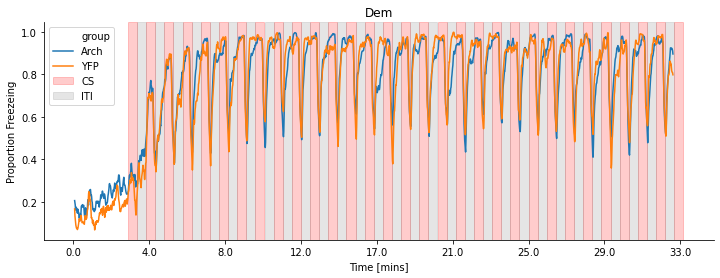

In [9]:
f, ax = plt.subplots(figsize=(12, 4))
freeze_ts_dem = get_freeze_ts(df)

ax = fill_background(ax)
ax = sns.lineplot(data=freeze_ts_dem, x="exp_time", 
                  y="was_freezing_dem", hue="group", 
                  ci=None,
                  ax=ax)
sns.despine()
ax.set_ylabel("Proportion Freezeing")
ax.set_xticklabels(np.round(ax.get_xticks() / 60))
ax.set_xlabel("Time [mins]")
ax.set_title("Dem")
plt.savefig("DemFreeze_ts.svg")

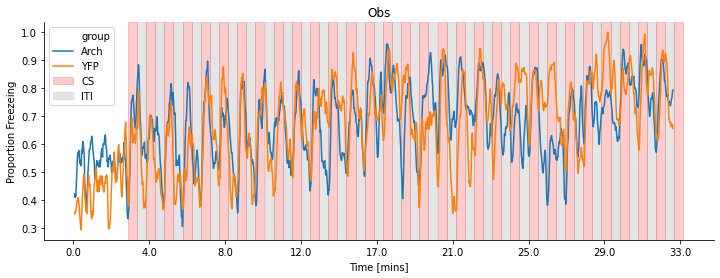

In [10]:
f, ax = plt.subplots(figsize=(12, 4))
freeze_ts_dem = get_freeze_ts(df, col="was_freezing_obs")

ax = fill_background(ax)
ax = sns.lineplot(data=freeze_ts_dem, x="exp_time", 
                  y="was_freezing_obs", hue="group", 
                  ci=None,
                  ax=ax)
sns.despine()
ax.set_ylabel("Proportion Freezeing")
ax.set_xticklabels(np.round(ax.get_xticks() / 60))
ax.set_xlabel("Time [mins]")
ax.set_title("Obs")
plt.savefig("ObsFreeze_ts.svg")

In [12]:
def get_corr_ts(df, rolling_window=10):
    grouped = (
            df
    .dropna()
    .groupby(["group", np.round(df.exp_time)])
    [["was_freezing_dem", "was_freezing_obs"]]
    .mean()
    .reset_index()
    .dropna())
    frames = []
    for g in grouped.group.unique():
        dfs = grouped.loc[lambda x: x.group == g].copy()
        dfs = dfs.assign(rolling_corr = dfs['was_freezing_dem']
            .rolling(rolling_window)
            .corr(dfs['was_freezing_obs']))
        frames.append(dfs)
    return pd.concat(frames)

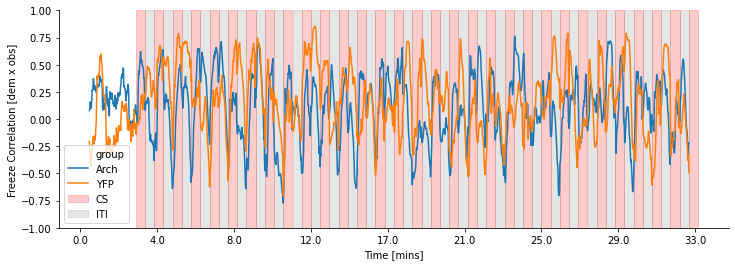

In [13]:
df_corr = get_corr_ts(df, rolling_window=30)
df_corr.dropna()

f, ax = plt.subplots(figsize=(12, 4))
# freeze_ts["time"] = freeze_ts.exp_time.divide(60) 

ax = fill_background(ax)
ax = sns.lineplot(data=df_corr.dropna(), x="exp_time", 
                  y="rolling_corr", hue="group",
                  ax=ax)
sns.despine()
ax.set_ylabel("Freeze Correlation [dem x obs]")
ax.set_xticklabels(np.round(ax.get_xticks() / 60))
ax.set_xlabel("Time [mins]")
ax.set_ylim([-1, 1])
plt.savefig("FreezeCorr_ts.svg")

# Bouts

In [356]:
bouts = (
    df
    .groupby(["mouse_name", "group"])
    .apply(lambda x: mean_bouts(x.was_freezing_obs))
    .reset_index().rename(columns={0: "mean_bout"})
    .merge(df[["mouse_name", "fps"]].drop_duplicates())
    .assign(mean_bout=lambda x: x.mean_bout / x.fps)
    .assign(time_period="overall")
)

bouts_tt = (
    df
    .groupby(["mouse_name", "group", "trial_type"])
    .apply(lambda x: mean_bouts(x.was_freezing_obs))
    .reset_index().rename(columns={0: "mean_bout"})
    .merge(df[["mouse_name", "fps"]].drop_duplicates())
    .assign(mean_bout=lambda x: x.mean_bout / x.fps)
    .assign(time_period="overall")
)

bouts_ff = (
    df
        .dropna()
        .loc[lambda x: x.trial_num <= 5]
        .groupby(["mouse_name", "group", "trial_type"])
        .apply(lambda x: mean_bouts(x.was_freezing_obs))
        .reset_index().rename(columns={0: "mean_bout"})
        .merge(df[["mouse_name", "fps"]].drop_duplicates())
        .assign(mean_bout=lambda x: x.mean_bout / x.fps)
        .assign(time_period="First 5")
)
bouts_lf = (
    df
        .loc[lambda x: x.trial_num >= (x.trial_num.max() - 6)]
        .groupby(["mouse_name", "group", "trial_type"])
        .apply(lambda x: mean_bouts(x.was_freezing_obs))
        .reset_index().rename(columns={0: "mean_bout"})
        .merge(df[["mouse_name", "fps"]].drop_duplicates())
        .assign(mean_bout=lambda x: x.mean_bout / x.fps)
        .assign(time_period="Last 5")
)
bouts_fflf = pd.concat([bouts_ff, bouts_lf])

In [357]:
bouts.to_csv("bouts_overall.csv", index=False)
bouts_tt.to_csv("bouts_tt.csv", index=False)
bouts_fflf.to_csv("bouts_fflf.csv", index=False)

## Cross Correlation

### Overall

In [359]:
df_cc1 = (
    df
    .loc[lambda x: (x.exp_time >= 0) & (x.trial_num <= 30)]
    .groupby(["mouse_name", "group"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=500, standardise_range="sub"))
    .reset_index()
    .pipe(lambda x: x.groupby([x.mouse_name, x.group, np.round(x.lag)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)

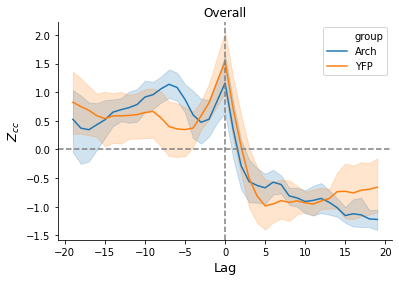

In [360]:
ax= sns.lineplot(
    data=df_cc1, 
    x="lag",
    y="cc",
    hue="group"
)

ax.set_title("Overall")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=13)
ax.set_xlabel("Lag", fontsize=13)
plt.savefig("CC_overall.svg")

A left > right imbalance indicates that the oberver is correlated with the past behaviour of the demonstrator, was this imbalance greater than what would be expected under chance?

In [363]:
from numpy.random import permutation
from sklearn.metrics import auc
from ezbootstrap import permutation_2sample

def auc_leftright(arr1, arr2, interval=29, num_lags=300):
    zcc = cross_correlation(arr1, arr2, num_lags=num_lags, standardise=True, standardise_range="sub")
    lags = cc_lags(zcc, interval)
    left_auc = auc(lags[lags < 0], zcc[lags < 0])
    right_auc = auc(lags[lags > 0], zcc[lags > 0])
    return left_auc - right_auc
    

sers = []
total = len(df.mouse_name.unique())
for i, mouse in enumerate(df.mouse_name.unique()):
    print(f"{(i / total) * 100}% completed")
    print(f"Mouse: {mouse}")
    dfs = df.loc[lambda x: x.mouse_name == mouse]
    fps = dfs.iloc[0].fps
    group = dfs.iloc[0].group
    obs, dem = dfs.was_freezing_obs.values, dfs.was_freezing_dem.values
    reps = permutation_2sample(dem, obs, 
                               lambda x, y: auc_leftright(x, y,interval=fps, num_lags=500),
                        size=500)
    oberserved = auc_leftright(dem, obs)
    p = np.mean(reps >= oberserved)
    sers.append(
        pd.DataFrame({
            "mouse_name": mouse,
            "group": group,
            "observed": oberserved,
            "p": p
        }, index=[0])
    )

df_stats =pd.concat(sers).reset_index().drop("index", axis=1)

0.0% completed
Mouse: O-Arch-1


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


4.761904761904762% completed
Mouse: O-Arch-10


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


9.523809523809524% completed
Mouse: O-Arch-11


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


14.285714285714285% completed
Mouse: O-Arch-12


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


19.047619047619047% completed
Mouse: O-Arch-2


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


23.809523809523807% completed
Mouse: O-Arch-3


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


28.57142857142857% completed
Mouse: O-Arch-4


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


33.33333333333333% completed
Mouse: O-Arch-5


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


38.095238095238095% completed
Mouse: O-Arch-6


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


42.857142857142854% completed
Mouse: O-Arch-7


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


47.61904761904761% completed
Mouse: O-Arch-8


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


52.38095238095239% completed
Mouse: O-Arch-9


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


57.14285714285714% completed
Mouse: O-YFP-1


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


61.904761904761905% completed
Mouse: O-YFP-10


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


66.66666666666666% completed
Mouse: O-YFP-3


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


71.42857142857143% completed
Mouse: O-YFP-4


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


76.19047619047619% completed
Mouse: O-YFP-5


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


80.95238095238095% completed
Mouse: O-YFP-6


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


85.71428571428571% completed
Mouse: O-YFP-7


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


90.47619047619048% completed
Mouse: O-YFP-8


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


95.23809523809523% completed
Mouse: O-YFP-9


c:\users\rory\repos\ezbootstrap\ezbootstrap\core.py:129: UserWarning: Numba compilation failed. Reverting to pure python


In [366]:
df_stats = (
    df_cc1
    .groupby("mouse_name")["cc"]
    .max()
    .reset_index()
    .merge(df_cc1[["mouse_name", "cc", "lag"]])
    .merge(df_stats)
)

In [368]:
df_stats.to_csv("CrossCorrOverall.csv", index=False)

## By Block

In [339]:
df_cc = (
    df
    .loc[lambda x: (x.exp_time >= 0) & (x.trial_num <= 30)]
    .groupby(["mouse_name", "trial_num", "trial_type", "group"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=310, standardise_range="sub"))
    .reset_index()
    .drop("level_4", axis=1)
    .pipe(lambda x: x.groupby([x.mouse_name, x.trial_type, x.group, np.round(x.lag)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
)

In [340]:
df_cc.head()

,mouse_name,trial_type,group,lag,trial_num,cc
0,O-Arch-1,CS,Arch,-12.0,15.5,-0.885611
1,O-Arch-1,CS,Arch,-11.0,15.5,-0.711386
2,O-Arch-1,CS,Arch,-10.0,15.5,-0.465642
3,O-Arch-1,CS,Arch,-9.0,15.5,-0.224596
4,O-Arch-1,CS,Arch,-8.0,15.5,0.026613


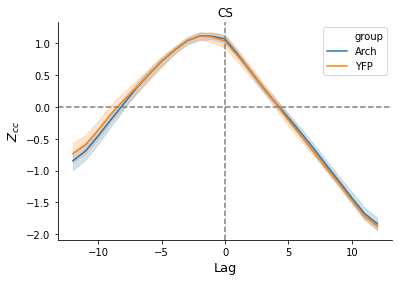

In [341]:
ax= sns.lineplot(
    data=df_cc.loc[lambda x: x.trial_type == "CS"], 
    x="lag",
    y="cc",
    hue="group"
)

ax.set_title("CS")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=13)
ax.set_xlabel("Lag", fontsize=13)
plt.savefig("CC_CS.svg")

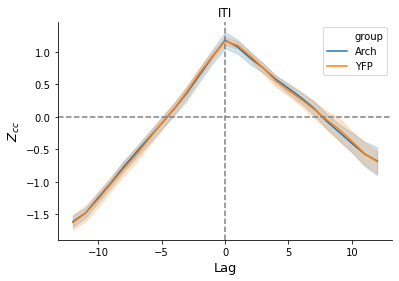

In [342]:
ax= sns.lineplot(
    data=df_cc.loc[lambda x: x.trial_type == "ITI"], 
    x="lag",
    y="cc",
    hue="group"
)

ax.set_title("ITI")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=13)
ax.set_xlabel("Lag", fontsize=13)
plt.savefig("CC_ITI.svg")

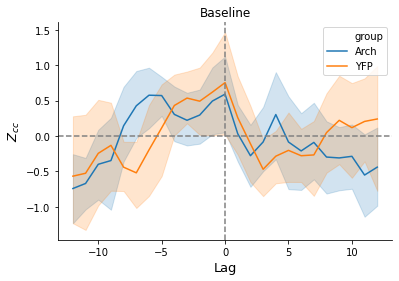

In [343]:
ax= sns.lineplot(
    data=df_cc.loc[lambda x: x.trial_type == "baseline"], 
    x="lag",
    y="cc",
    hue="group"
)

ax.set_title("Baseline")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=13)
ax.set_xlabel("Lag", fontsize=13)
plt.savefig("CC_Baseline.svg")

Quantigy left-right imbalance

In [344]:
def auc_leftright_nop(cc, lags):
    left_auc = auc(lags[lags < 0], cc[lags < 0])
    right_auc = auc(lags[lags > 0], cc[lags > 0])
    return left_auc - right_auc


def get_max_lag(x):
    cc = x.cc.values
    lag = x.lag.values
    max_cc = np.max(cc)
    max_cc_idx = np.argwhere(cc == max_cc)
    if len(max_cc_idx) > 1:
        max_cc_idx = max_cc_idx[0]
    max_lag = float(lag[max_cc_idx][0][0])
    return pd.Series({
        "max_cc": max_cc,
        "max_cc_lag": max_lag,
    })

df_stats = (
    df_cc
    .groupby(["mouse_name", "trial_type", "group"])
    .apply(lambda x: auc_leftright_nop(x.cc, x.lag))
    .reset_index()
    .rename(columns={0: "left_right_auc"})
)


df_stats = (
    df_cc
    .groupby(["mouse_name", "trial_type", "group"])
    .apply(lambda x: get_max_lag(x))
    .reset_index()
    .merge(df_stats)
)
df_stats.head()

,mouse_name,trial_type,group,max_cc,max_cc_lag,left_right_auc
0,O-Arch-1,CS,Arch,1.107212,-0.0,8.729889
1,O-Arch-1,ITI,Arch,1.379473,-0.0,-6.069177
2,O-Arch-1,baseline,Arch,2.219961,-1.0,0.875571
3,O-Arch-10,CS,Arch,1.297757,-2.0,11.064695
4,O-Arch-10,ITI,Arch,1.532712,-0.0,-4.242882


In [345]:
df_stats.to_csv("CC_BLOCKS.csv", index=False)

## CC Over time 

In [346]:
df_cc_ff = (
    df
    .dropna()
    .loc[lambda x: x.trial_type.isin(["CS", "ITI"])]
    .loc[lambda x: (x.exp_time >= 0) & (x.trial_num <= 30)]
    .loc[lambda x: x.trial_num <= 5]
    .groupby(["mouse_name", "trial_num", "trial_type", "group"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=310, standardise_range="sub"))
    .reset_index()
    .drop("level_4", axis=1)
    .pipe(lambda x: x.groupby([x.mouse_name, x.trial_type, x.group, np.round(x.lag)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
    .assign(time_period="First 5")
)


df_cc_lf = (
    df
    .dropna()
    .loc[lambda x: x.trial_type.isin(["CS", "ITI"])]
    .loc[lambda x: x.trial_num >= (x.trial_num.max() - 6)]
    .groupby(["mouse_name", "trial_num", "trial_type", "group"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=310, standardise_range="sub"))
    .reset_index()
    .drop("level_4", axis=1)
    .pipe(lambda x: x.groupby([x.mouse_name, x.trial_type, x.group, np.round(x.lag)]))
    .mean()
    .drop("lag", axis=1)
    .reset_index()
    .assign(time_period="Last 5")
)



df_cc_fflf = pd.concat([df_cc_ff, df_cc_lf])

In [347]:
df_cc_fflf.time_period.unique()

array(['First 5', 'Last 5'], dtype=object)

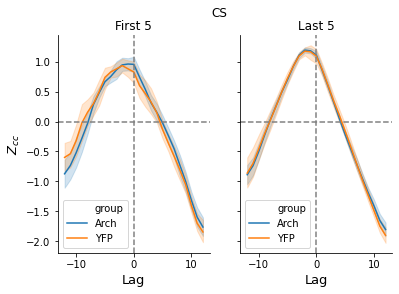

In [348]:
f, ax_list = plt.subplots(ncols=2, sharey=True)

for i, time_period in enumerate(df_cc_fflf.time_period.unique()):
    ax = ax_list.flatten()[i]
    ax = sns.lineplot(
        data=df_cc_fflf.loc[lambda x: (x.trial_type == "CS") & (x.time_period == time_period)], 
        x="lag",
        y="cc",
        hue="group",
        ax=ax
    )

    ax.set_title(f"{time_period}")
    ax.axhline(0, linestyle="dashed", color="grey")
    ax.axvline(0, linestyle="dashed", color="grey")
    sns.despine()
    ax.set_ylabel("$Z_{cc}$", fontsize=13)
    ax.set_xlabel("Lag", fontsize=13)

f.suptitle("CS")
plt.savefig("CC_CS_fflf.svg")

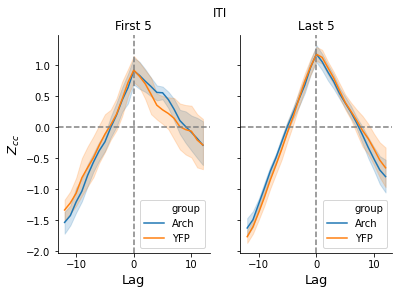

In [349]:
f, ax_list = plt.subplots(ncols=2, sharey=True)

for i, time_period in enumerate(df_cc_fflf.time_period.unique()):
    ax = ax_list.flatten()[i]
    ax = sns.lineplot(
        data=df_cc_fflf.loc[lambda x: (x.trial_type == "ITI") & (x.time_period == time_period)], 
        x="lag",
        y="cc",
        hue="group",
        ax=ax
    )

    ax.set_title(f"{time_period}")
    ax.axhline(0, linestyle="dashed", color="grey")
    ax.axvline(0, linestyle="dashed", color="grey")
    sns.despine()
    ax.set_ylabel("$Z_{cc}$", fontsize=13)
    ax.set_xlabel("Lag", fontsize=13)

f.suptitle("ITI")
plt.savefig("CC_ITI_fflf.svg")

In [350]:
df_stats = (
    df_cc_fflf

    .groupby(["mouse_name", "trial_type", "group", "time_period"])
    .apply(lambda x: auc_leftright_nop(x.cc, x.lag))
    .reset_index()
    .rename(columns={0: "left_right_auc"})
)


df_stats = (
    df_cc_fflf
    .groupby(["mouse_name", "trial_type", "group", "time_period"])
    .apply(lambda x: get_max_lag(x))
    .reset_index()
    .merge(df_stats)
)
df_stats.to_csv("CC_BLOCKS_FFLF.csv", index=False)

## US

In [351]:
df_cc_us = (
    df
    .dropna()
    .loc[lambda x: x.trial_type == "ITI"]
    .loc[lambda x: x.aligned <= 2]
    .groupby(["mouse_name", "trial_num", "trial_type", "group"])
    .apply(lambda x: corss_corr_by(x, standardise=True, num_lags=25, standardise_range="sub"))
    .reset_index()
    .drop("level_4", axis=1)
    .pipe(lambda x: x.groupby([x.mouse_name, x.trial_type, x.group, np.round(x.lag, 1)]))
    .mean()
    .drop(["lag", "trial_num"], axis=1)
    .reset_index()
)

c:\users\rory\.conda\envs\ah_vids\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide


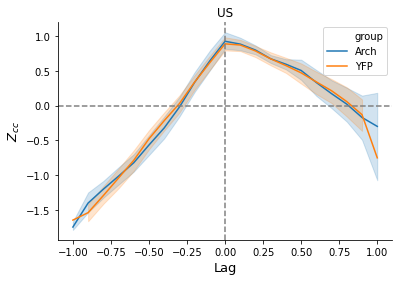

In [352]:
ax= sns.lineplot(
    data=df_cc_us, 
    x="lag",
    y="cc",
    hue="group"
)

ax.set_title("US")
ax.axhline(0, linestyle="dashed", color="grey")
ax.axvline(0, linestyle="dashed", color="grey")
sns.despine()
ax.set_ylabel("$Z_{cc}$", fontsize=13)
ax.set_xlabel("Lag", fontsize=13)
plt.savefig("CC_US.svg")

In [353]:
df_stats = (
    df_cc_us

    .groupby(["mouse_name", "group"])
    .apply(lambda x: auc_leftright_nop(x.cc, x.lag))
    .reset_index()
    .rename(columns={0: "left_right_auc"})
)


df_stats = (
    df_cc_us
    .groupby(["mouse_name", "group"])
    .apply(lambda x: get_max_lag(x))
    .reset_index()
    .merge(df_stats)
)

In [355]:
df_stats.to_csv("CC_US.csv", index=False)